# Exercise 01: Sampling Theorem
\- Gugliemo Grillo

<div>
<center>
    <img src="https://i.ibb.co/BBBWNCt/Sampling.png" width="400"/>
</center>
</div>

### Continuous Fourier Transform
The continuous Fourier transform can be evaluated as
$$ s(\omega) = \int_{-\infty}^{+\infty}s(t) e^{-i \omega t} dt$$

For this problem the integral was solved using Wolfram Mathematica. If in doubt, check on [Wolfram|Alpha](https://www.wolframalpha.com/). The solution is:
$$s(\omega) = -\frac{i}{2\sqrt{2\pi}} \bigl(\frac{1}{1/\Delta T-i(\omega+2\pi\nu_0)} - \frac{1}{1/\Delta T-i(\omega-2\pi\nu_0)} \bigr)$$

In [70]:
# packages used
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Given constans
DeltaT = 10
f0 = 10
fs = [20, 21, 50, 100]

# Function definition
def signalT(t):
    return np.exp(-1*t/DeltaT)*np.heaviside(t, 0)*np.sin(2*np.pi*f0*t)

def signalF(f):
    return 1j/(2*np.sqrt(2*np.pi))*(
             1/(1/DeltaT - 1j*(f+2*np.pi*f0))
            -1/(1/DeltaT - 1j*(f-2*np.pi*f0)))

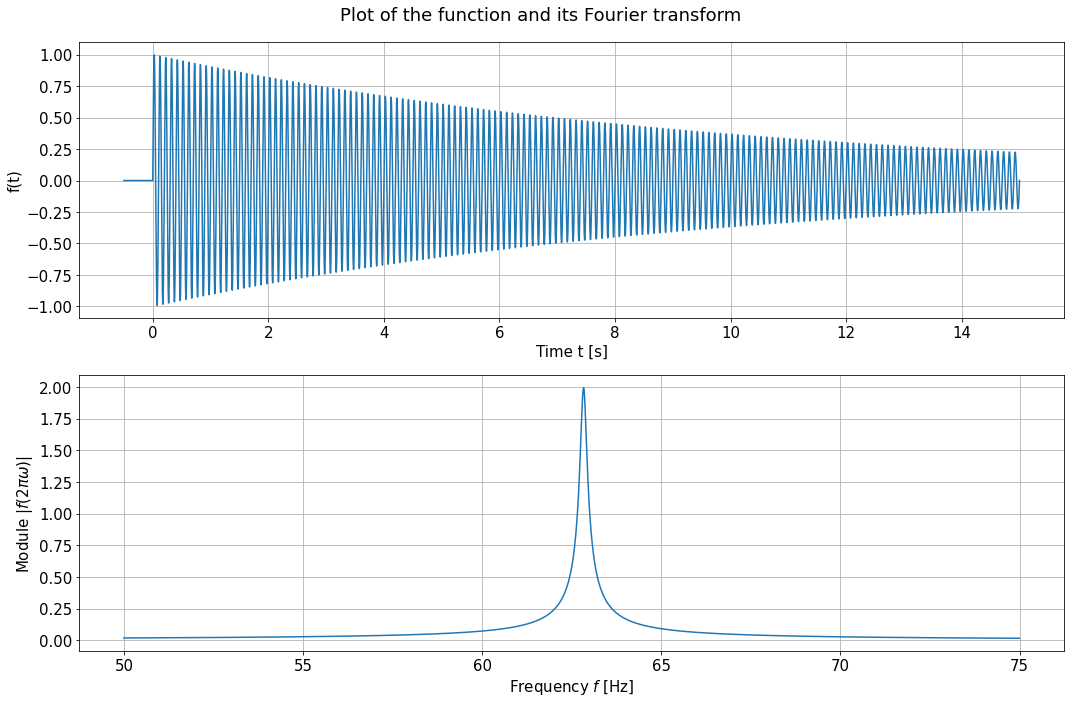

In [88]:
t = np.linspace(-0.5, 15, int(1e6))
f = np.linspace(50, 75, int(1e6))

plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(2,1, figsize=(15, 10))
fig.suptitle('Plot of the function and its Fourier transform')

axis[0].plot(t, signalT(t) )
axis[0].set_xlabel("Time t [s]")
axis[0].set_ylabel("f(t)")
axis[0].grid(True, which="both")

axis[1].plot(f, np.abs(signalF(f)) )
axis[1].set_xlabel(r"Frequency $f$ [Hz]")
axis[1].set_ylabel(r"Module $|f(2 \pi \omega)|$")
axis[1].grid(True, which="both")

plt.tight_layout()
plt.show()

### Sample and estimation of aliases for the given frequencies

Aliases are estimated as an error. The Fourier Transform is reconstructed from the samples (sampled ad-hoc) and the error is evaluated as
$$\text{alias}=\sigma ^ 2 = \sum_\omega \frac{(f(\omega)-f_{reconstructed}(\omega))^2}{N}$$

As $N$ is the same for each frequency and we are only interested in comparing the results the division by N wasn't performed.

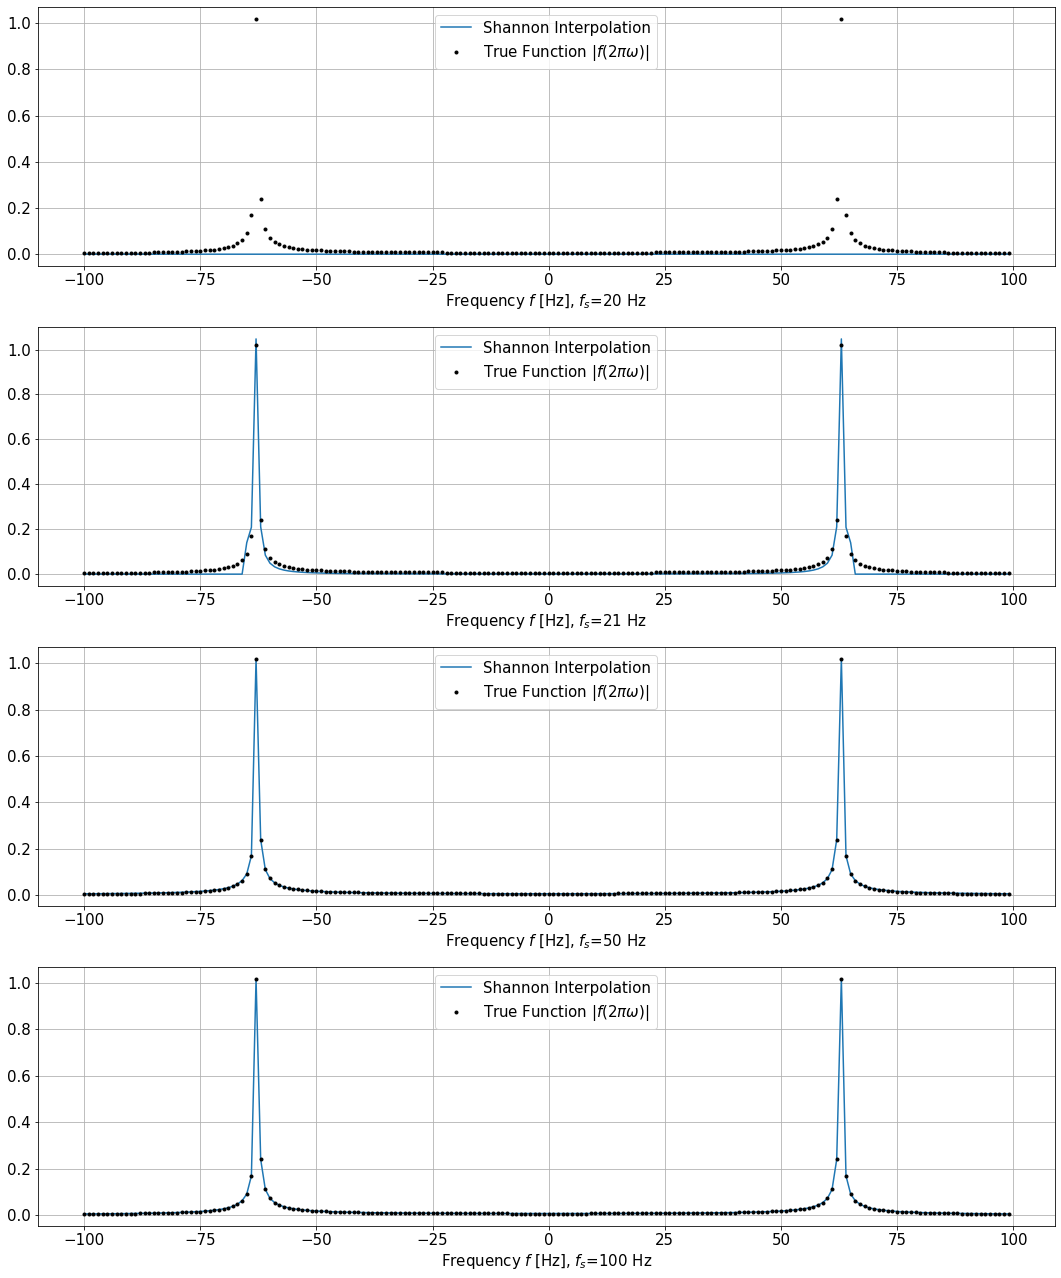

Alias for 20:	2.3483655649263593
Alias for 21:	0.048722829682008105
Alias for 50:	0.00017230063943929737
Alias for 100:	9.076413596811795e-06


In [108]:
def shannon_interpolation_omega(omega, T):
    s=0
    for n in np.arange(-200, 200):
        # Points are sampled in real time
        s += signalF(omega+n*2*np.pi/T) #
        
    return (np.heaviside(omega+np.pi/T, 0) - np.heaviside(omega-np.pi/T, 0)) * s


plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(4, 1, figsize=(15, 18))

f = np.arange(-100, 100, 1)
alias = fs.copy()

for i, fsam in enumerate(fs):
    T = 1/fsam
    
    reconstruction = np.zeros(f.shape[0])
    for j in range(f.shape[0]):
        reconstruction[j] = np.abs(
            shannon_interpolation_omega(f[j], T) )
    
    reference = np.abs( signalF(f) )
    axis[i].plot(f,  reconstruction, label='Shannon Interpolation')
    axis[i].plot(f, reference, ".", color='black', label='True Function |$f(2 \pi \omega)$|')
    axis[i].set_xlabel(r"Frequency $f$ [Hz], $f_s$="+str(fs[i])+" Hz" )
    axis[i].grid(True, which="both")
    axis[i].legend()
    
    alias[i] = np.sum( (reconstruction-reference) ** 2 )
    
plt.tight_layout()
plt.show()

for i, fsam in enumerate(fs):
    print("Alias for "+str(fsam)+":\t"+str(alias[i]) )

We can check that, indeed, with an higher value of sampling frequency, the error diminishes.

### Error estimation within given ranges
The sampling can be done by saving points with frequency $f_s$. The reconstruction is done via Shannon Interpolation method:
$$ s'[t] = \sum _{k=-\infty}^{+\infty} s(kT)\ sinc \bigl(\frac{\pi}{T}(t-kT) \bigr)$$

In order to have a lossless reconstruction the sampling frequency must be at least twice as big at the higher frequency of the signal. If we look at the FT graph we can see that the maximum frequency is well over the $\nu_0 = 10 Hz$ given. That's because the exponential has a frequency range of it's own. The maximum frequency can be estimated to be around 60HZ and we expect the first two graphs to be inaccurate.


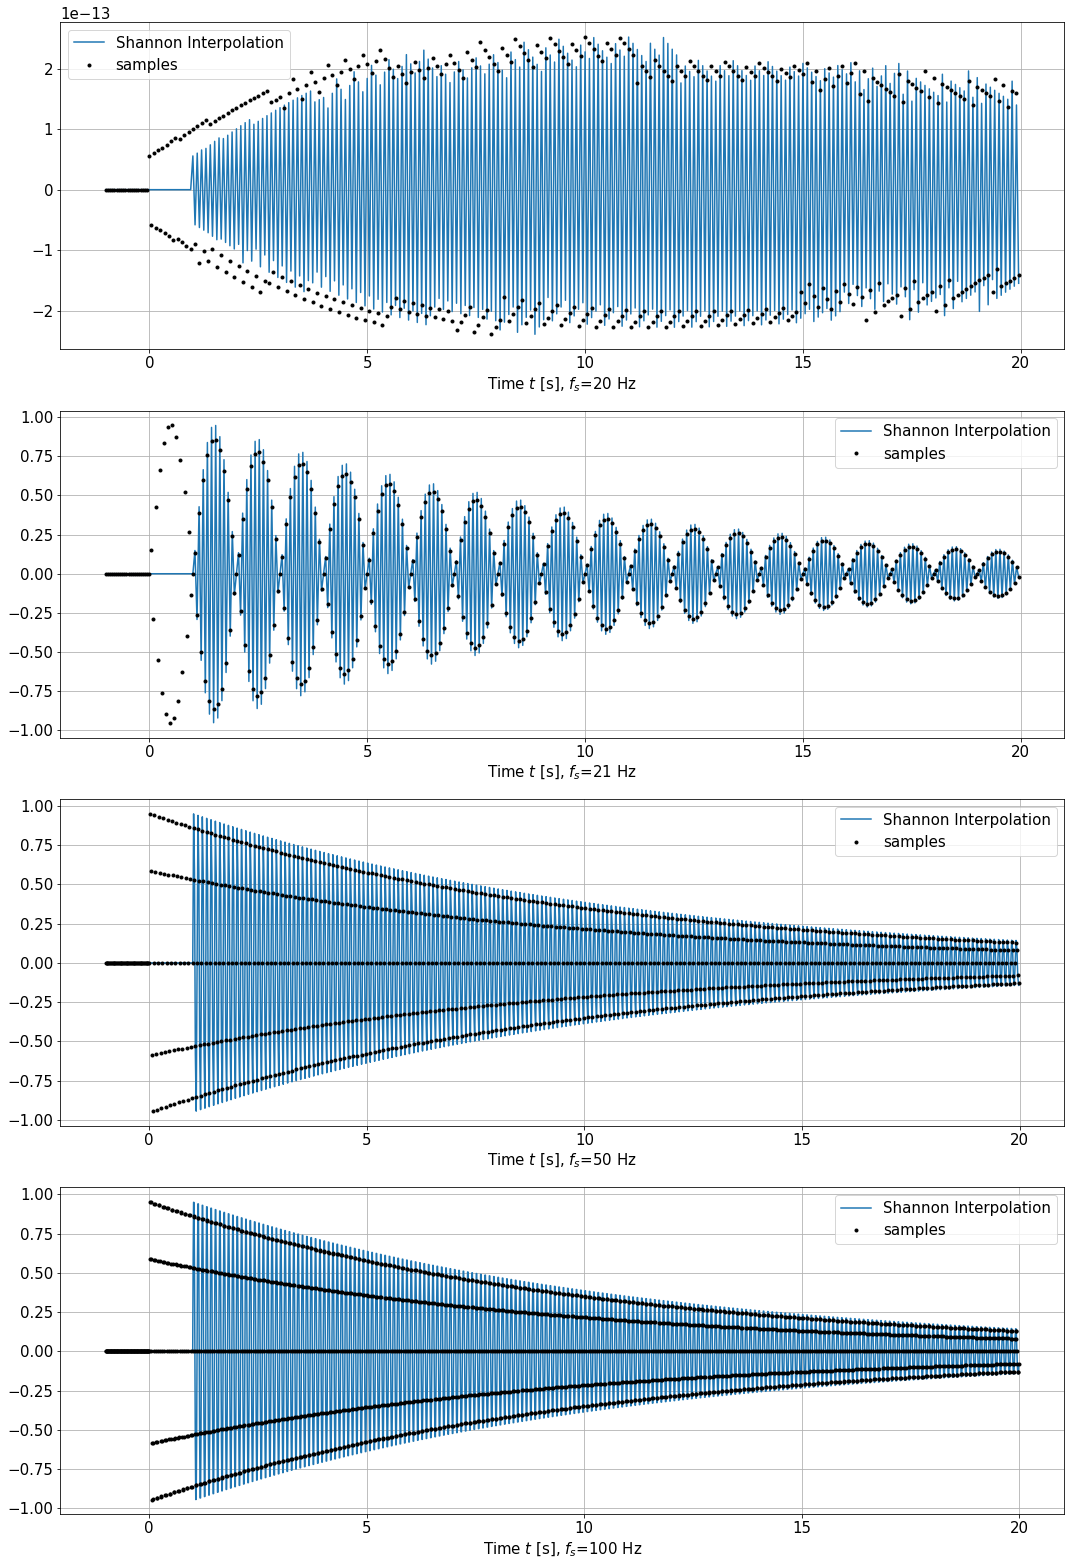

In [113]:
# Interval limits given in the third point
Ti, Tf = -1, 20

def shannon_interpolation_T(t, points, T):
    s=0
    for k in range(points.shape[0]):
        # NB: for python sinc(x) = sin(pi*x)/(pi*x)
        s += points[k]*np.sinc( (t-k*T)/T )
    return s

plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(4, 1, figsize=(15, 22))

for i, fsam in enumerate(fs):
    T = 1/fsam # Time step from sampling frequency
    t = np.arange(Ti, Tf, step=T)
    
    t_sampling = np.arange(start=Ti, stop=Tf, step=T)
    samples = signalT(t_sampling)
    
    reconstruction = np.zeros(t.shape[0])
    for j in range(t.shape[0]):
        reconstruction[j] = shannon_interpolation_T(t[j], samples, T)
    
    axis[i].plot(t,  reconstruction, label='Shannon Interpolation')
    axis[i].plot(t_sampling, samples, ".", color='black', label='samples')
    axis[i].set_xlabel(r"Time $t$ [s], $f_s$="+str(fs[i])+" Hz" )
    axis[i].grid(True, which="both")
    axis[i].legend()
    
    alias[i] = np.sum( (reconstruction-signalT(t))**2)
    
plt.tight_layout()
plt.show()